https://www.youtube.com/watch?v=OIenNRt2bjg intro to pytorch.

### Imports

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

### Defining the verdict model compartments. 

- gradient_strength = np.array([np.sqrt(b_values[i])/(gamma*delta[i]*np.sqrt(Delta[i]-delta[i]/3)) for i,_ in enumerate(b_values)])
    -   What does the underscore mean? It might mean an usused variable, but there's only 1 dimension to b_values
    - If I did for in enumerate(b_values) then you get back a index and a value, but the i,_ returns just the index and ignores the value. It is a blank unused variable. 

- What is the purpose of the error function?
    - First look at where the astrosticks formula is from, then ask again.

In [73]:

# simulate data according to verdict model - there is a function for each of the three compartments
# when you do it for bbb-fexi, this will change

def sphere(r):
    """ Returns 1x10 array
    """
    # Create 1d array with these 100 values
    SPHERE_TRASCENDENTAL_ROOTS = np.r_[
        # 0.,
        2.081575978, 5.940369990, 9.205840145,
        12.40444502, 15.57923641, 18.74264558, 21.89969648,
        25.05282528, 28.20336100, 31.35209173, 34.49951492,
        37.64596032, 40.79165523, 43.93676147, 47.08139741,
        50.22565165, 53.36959180, 56.51327045, 59.65672900,
        62.80000055, 65.94311190, 69.08608495, 72.22893775,
        75.37168540, 78.51434055, 81.65691380, 84.79941440,
        87.94185005, 91.08422750, 94.22655255, 97.36883035,
        100.5110653, 103.6532613, 106.7954217, 109.9375497,
        113.0796480, 116.2217188, 119.3637645, 122.5057870,
        125.6477880, 128.7897690, 131.9317315, 135.0736768,
        138.2156061, 141.3575204, 144.4994207, 147.6413080,
        150.7831829, 153.9250463, 157.0668989, 160.2087413,
        163.3505741, 166.4923978, 169.6342129, 172.7760200,
        175.9178194, 179.0596116, 182.2013968, 185.3431756,
        188.4849481, 191.6267147, 194.7684757, 197.9102314,
        201.0519820, 204.1937277, 207.3354688, 210.4772054,
        213.6189378, 216.7606662, 219.9023907, 223.0441114,
        226.1858287, 229.3275425, 232.4692530, 235.6109603,
        238.7526647, 241.8943662, 245.0360648, 248.1777608,
        251.3194542, 254.4611451, 257.6028336, 260.7445198,
        263.8862038, 267.0278856, 270.1695654, 273.3112431,
        276.4529189, 279.5945929, 282.7362650, 285.8779354,
        289.0196041, 292.1612712, 295.3029367, 298.4446006,
        301.5862631, 304.7279241, 307.8695837, 311.0112420,
        314.1528990
    ]

    D = 2
    gamma = 2.67e2
    radius = r

    b_values = np.array([1e-6, 0.090, 1e-6, 0.500, 1e-6, 1.5, 1e-6, 2, 1e-6, 3])
    Delta = np.array([23.8, 23.8, 23.8, 31.3, 23.8, 43.8, 23.8, 34.3, 23.8, 38.8])
    delta = np.array([3.9, 3.9, 3.9, 11.4, 3.9, 23.9, 3.9, 14.4, 3.9, 18.9])

    #calculate gradstrength for each b value and (D/d)elta. i is an index. 
    gradient_strength = np.array([np.sqrt(b_values[i])/(gamma*delta[i]*np.sqrt(Delta[i]-delta[i]/3)) for i,_ in enumerate(b_values)])

    # alpha, alpha2 and alpha2d are a 100x1 arrays, the maths is elementwise. 
    alpha = SPHERE_TRASCENDENTAL_ROOTS / radius
    #** means squared, also done elementwise
    alpha2 = alpha ** 2
    alpha2D = alpha2 * D

    #create an array of 1x10. Seems to always be the same. 
    first_factor = -2 * (gamma * gradient_strength) ** 2 / D
    
    #create zeros array with lengths as sizes. In this case 100x10
    summands = np.zeros((len(SPHERE_TRASCENDENTAL_ROOTS),len(b_values)))
    
    #create 100x10 array called summands
    for i,_ in enumerate(delta):
        summands[:,i] = (
            alpha ** (-4) / (alpha2 * radius ** 2 - 2) *
            (
                2 * delta[i] - (
                    2 +
                    np.exp(-alpha2D * (Delta[i] - delta[i])) -
                    2 * np.exp(-alpha2D * delta[i]) -
                    2 * np.exp(-alpha2D * Delta[i]) +
                    np.exp(-alpha2D * (Delta[i] + delta[i]))
                ) / (alpha2D)
            )
        )
    #sum all 100 elements in summands, and create E, an array which is 10x1
    E = np.exp(
        first_factor *
        summands.sum()
    )
    return E

def ball(d):
    """ Returns 1x10 array
    """
    bvals = np.array([1e-6, 0.090, 1e-6, 0.500, 1e-6, 1.5, 1e-6, 2, 1e-6, 3])
    E_ball = np.exp(-bvals * d)
    
    #E_ball is a 1x10 array
    return E_ball

def astrosticks(l):
    """ Returns 1x10 array
    """
    bvals = np.array([1e-6, 0.090, 1e-6, 0.500, 1e-6, 1.5, 1e-6, 2, 1e-6, 3])
    lambda_par = l

    #make an array filled with ones, same size as bvals (1x10)
    E_mean = np.ones_like(bvals)
    #erf() is the error function, returns values between -1 to 1. I think it is like normalising a value perhaps.
    E_mean = ((np.sqrt(np.pi) * erf(np.sqrt(bvals * lambda_par))) /
                (2 * np.sqrt(bvals * lambda_par)))

    #E_mean is a 1x10 array
    return E_mean 


### Defining number of voxels and verdict parameters
- Why is 10 an important and recurring number? Is that the number of b values used?
- What does expand_dims() do? It seems to add an extra dimension, but why is that needed?
- fvasc seems to be a fraction, not an absolute value. Is this different to fic and fees and why?
    - They all eventually become fractions, a few lines later on. 

In [74]:

nvox = 100000 # number of voxels to simulate

#These 3 are all 1x nvox arrays. 
radii = np.random.uniform(0.001,15,nvox) # free parameter - cell radius
dees = np.random.uniform(0.5,3,nvox) # free parameter - EES diffusivity
lambdapar = np.repeat(2,nvox) # fixed parameter

# These are all nvox x 10 arrays. (10 is number of bvals, so I think acquisitions.)
E_stick = np.array([astrosticks(l) for l in lambdapar]) 
E_ball = np.array([ball(d) for d in dees])
E_sphere = np.array([sphere(r) for r in radii])

# nvox x 1 arrays. 
fic = np.expand_dims(np.random.uniform(0.001, 0.999, nvox), axis=1) # free parameter - IC volume fraction
fees = np.expand_dims(np.random.uniform(0.001, 0.999, nvox), axis=1) # free parameter - EES volume fraction
fvasc = 1 - fic - fees # calculate VASC volume fraction
fvasc = fvasc/(fic + fees + fvasc)

A = fvasc
#Smallest value now becomes the new zero, similar to kelvin and celsius. 
#Done for all elements, so normA is nvox x 1 array
normA = A - min(A)
fvasc = 0.2 * (normA/max(normA)) # constraining fvasc to be realistic for prostate tissue (under 0.2)

#changing into fractions. 
fic = fic/(fic + fees + fvasc)
fees = fees/(fic + fees + fvasc)

# These are all nvox x 10 arrays. Adding noise
E_vox = fees*E_ball + fic*E_sphere + fvasc*E_stick
E_vox_real = E_vox + np.random.normal(scale=0.02, size=np.shape(E_vox)) # adding rician noise, snr = 50
E_vox_imag = np.random.normal(scale=0.02, size=np.shape(E_vox))
E_vox = np.sqrt(E_vox_real**2 + E_vox_imag**2) # these are the simulated signals


### Section for comparing to NLLS fitting.
Don't know what it does yet.

In [75]:


'''

## this section will be useful when you want to compare it to NLLS fitting, i'm commenting it out for now

b_values = np.array([1e-6, 90, 1e-6, 500, 1e-6, 1500, 1e-6, 2000, 1e-6, 3000])
bvaluesSI = np.array([i * 1e6 for i in b_values])
Delta = np.array([0.0238, 0.0238, 0.0238, 0.0313, 0.0238, 0.0438, 0.0238, 0.0343, 0.0238, 0.0388])
delta = np.array([0.0039, 0.0039, 0.0039, 0.0114, 0.0039, 0.0239, 0.0039, 0.0144, 0.0039, 0.0189])
gradient_directions = np.loadtxt('./verdict_graddirs.txt', delimiter=',')
acq_scheme = acquisition_scheme_from_bvalues(bvaluesSI, gradient_directions, delta, Delta)

spheresim = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=2e-9)
ballsim = gaussian_models.G1Ball()
sticksim = cylinder_models.C1Stick(lambda_par=2e-9)
astro = sticksim.spherical_mean(acq_scheme)

from dmipy.core.modeling_framework import MultiCompartmentModel
verdict_mod = MultiCompartmentModel(models=[spheresim, ballsim, sticksim])
verdict_mod.set_parameter_optimization_bounds('G1Ball_1_lambda_iso', [0.5e-9, 3e-9])
verdict_mod.set_parameter_optimization_bounds('partial_volume_0', [0.001, 0.999])
verdict_mod.set_parameter_optimization_bounds('partial_volume_1', [0.001, 0.999])
verdict_mod.set_parameter_optimization_bounds('partial_volume_1', [0.001, 0.199])
verdict_mod.set_parameter_optimization_bounds('G1Ball_1_lambda_iso', [0.5e-9, 3e-9])


res = verdict_mod.fit(acq_scheme, E_vox)
f_ic = res.fitted_parameters['partial_volume_0']
f_ees = res.fitted_parameters['partial_volume_1']
f_vasc = res.fitted_parameters['partial_volume_2']
r = res.fitted_parameters['S4SphereGaussianPhaseApproximation_1_diameter']/2
d_ees = res.fitted_parameters['G1Ball_1_lambda_iso']
'''


"\n\n## this section will be useful when you want to compare it to NLLS fitting, i'm commenting it out for now\n\nb_values = np.array([1e-6, 90, 1e-6, 500, 1e-6, 1500, 1e-6, 2000, 1e-6, 3000])\nbvaluesSI = np.array([i * 1e6 for i in b_values])\nDelta = np.array([0.0238, 0.0238, 0.0238, 0.0313, 0.0238, 0.0438, 0.0238, 0.0343, 0.0238, 0.0388])\ndelta = np.array([0.0039, 0.0039, 0.0039, 0.0114, 0.0039, 0.0239, 0.0039, 0.0144, 0.0039, 0.0189])\ngradient_directions = np.loadtxt('./verdict_graddirs.txt', delimiter=',')\nacq_scheme = acquisition_scheme_from_bvalues(bvaluesSI, gradient_directions, delta, Delta)\n\nspheresim = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=2e-9)\nballsim = gaussian_models.G1Ball()\nsticksim = cylinder_models.C1Stick(lambda_par=2e-9)\nastro = sticksim.spherical_mean(acq_scheme)\n\nfrom dmipy.core.modeling_framework import MultiCompartmentModel\nverdict_mod = MultiCompartmentModel(models=[spheresim, ballsim, sticksim])\nverdict_mod.set_parame

### Creating the neural network
+ What does self.b_values = b_values do?
    + assignes b values to the "self" version  of b values, ie for that time it was called.
+ self.encoder = nn.Sequential(*self.layers, nn.Linear(len(b_values), nparams))
    What does this line do? Seems inportant
+ Should this be D instead of 2? It is in the first box, so why is this different?
    + alpha2D = alpha2 * 2
    + NameError: name 'D' is not defined is the error if I put D in. 
+ What is going on with all the unsqeezes?
+ What makes summands be 100 long? 
    + I get the other 2 dimensions
+ What is X?

In [76]:

class Net(nn.Module): # this is the neural network

    #defining the init and foward pass functions. 

    def __init__(self, b_values, Delta, delta, gradient_strength, nparams):
        super(Net, self).__init__()

        self.b_values = b_values
        self.Delta = Delta
        self.delta = delta
        self.gradient_strength = gradient_strength


        #defining the layers that we want. 
        # 3 layers with 10 (no. of b_values) nodes. See paper.
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(b_values), len(b_values)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(b_values), nparams))

    def forward(self, X):
        """
        constrain f_ic, f_ees, r, d_ees and calculate X.
        """
        params = torch.nn.functional.softplus(self.encoder(X))
        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive.


        #params seems be a table containing each variable in a new column. 
        #unsqueeze adds an additional dimension. 
        f_ic = torch.clamp(params[:,0].unsqueeze(1), min=0.001, max=0.999) # parameter constraints
        f_ees = torch.clamp(params[:,1].unsqueeze(1), min=0.001, max=0.999)
        r = torch.clamp(params[:,2].unsqueeze(1), min=0.001, max=14.999)
        d_ees = torch.clamp(params[:,3].unsqueeze(1), min=0.5, max=3)

        # Create 1d array with these 100 values
        SPHERE_TRASCENDENTAL_ROOTS = np.r_[
        # 0.,
        2.081575978, 5.940369990, 9.205840145,
        12.40444502, 15.57923641, 18.74264558, 21.89969648,
        25.05282528, 28.20336100, 31.35209173, 34.49951492,
        37.64596032, 40.79165523, 43.93676147, 47.08139741,
        50.22565165, 53.36959180, 56.51327045, 59.65672900,
        62.80000055, 65.94311190, 69.08608495, 72.22893775,
        75.37168540, 78.51434055, 81.65691380, 84.79941440,
        87.94185005, 91.08422750, 94.22655255, 97.36883035,
        100.5110653, 103.6532613, 106.7954217, 109.9375497,
        113.0796480, 116.2217188, 119.3637645, 122.5057870,
        125.6477880, 128.7897690, 131.9317315, 135.0736768,
        138.2156061, 141.3575204, 144.4994207, 147.6413080,
        150.7831829, 153.9250463, 157.0668989, 160.2087413,
        163.3505741, 166.4923978, 169.6342129, 172.7760200,
        175.9178194, 179.0596116, 182.2013968, 185.3431756,
        188.4849481, 191.6267147, 194.7684757, 197.9102314,
        201.0519820, 204.1937277, 207.3354688, 210.4772054,
        213.6189378, 216.7606662, 219.9023907, 223.0441114,
        226.1858287, 229.3275425, 232.4692530, 235.6109603,
        238.7526647, 241.8943662, 245.0360648, 248.1777608,
        251.3194542, 254.4611451, 257.6028336, 260.7445198,
        263.8862038, 267.0278856, 270.1695654, 273.3112431,
        276.4529189, 279.5945929, 282.7362650, 285.8779354,
        289.0196041, 292.1612712, 295.3029367, 298.4446006,
        301.5862631, 304.7279241, 307.8695837, 311.0112420,
        314.1528990
        ]
        
        # all are 100x1 arrays
        alpha = torch.FloatTensor(SPHERE_TRASCENDENTAL_ROOTS) / (r)
        alpha2 = alpha ** 2
        alpha2D = alpha2 * 2

        #add extra dimension
        alpha = alpha.unsqueeze(1)
        alpha2 = alpha2.unsqueeze(1)
        alpha2D = alpha2D.unsqueeze(1)

        gamma = 2.675987e2
        #elsewhere gradient_strength is 10x1, so I think first factor is also 10x1.
        first_factor = -2*(gamma*self.gradient_strength)**2 / 2

        #adds 2 dimensions. 
        delta = self.delta.unsqueeze(0).unsqueeze(2)
        Delta = self.Delta.unsqueeze(0).unsqueeze(2)
        
        #Size of summands is [128, 10, 100]
        #128 is batch size, 10 is b_values, not sure what 100 is?
        summands = (alpha ** (-4) / (alpha2 * (r.unsqueeze(2))**2 - 2) * (
                            2 * delta - (
                            2 +
                            torch.exp(-alpha2D * (Delta - delta)) -
                            2 * torch.exp(-alpha2D * delta) -
                            2 * torch.exp(-alpha2D * Delta) +
                            torch.exp(-alpha2D * (Delta + delta))
                        ) / (alpha2D)
                    )
                )
         
        # this is where you will eventually need to tweak the network to be bbb-fexi rather than verdict

        #erf() is error function.
        #xi,xii,xiii and X are all 128x10. So batch size x 10 b_values most likely.
        xi = (1 - f_ic - f_ees) * ((np.sqrt(np.pi) * torch.erf(np.sqrt(self.b_values * 2))) /
                (2 * np.sqrt(self.b_values * 2)))
        xii = f_ic * torch.exp(torch.FloatTensor(first_factor) * torch.sum(summands, 2))
        xiii = f_ees * torch.exp(-self.b_values * d_ees)       
        X = xi + xii + xiii

        return X, f_ic, f_ees, r, d_ees



### NN continued

In [77]:


# define network
nparams = 4
b_values = torch.FloatTensor([1e-6, 0.090, 1e-6, 0.500, 1e-6, 1.5, 1e-6, 2, 1e-6, 3])
Delta = torch.FloatTensor([23.8, 23.8, 23.8, 31.3, 23.8, 43.8, 23.8, 34.3, 23.8, 38.8])
delta = torch.FloatTensor([3.9, 3.9, 3.9, 11.4, 3.9, 23.9, 3.9, 14.4, 3.9, 18.9])
gamma = 2.67e2
#gradient_strength is 10x1.
gradient_strength = torch.FloatTensor([np.sqrt(b_values[i])/(gamma*delta[i]*np.sqrt(Delta[i]-delta[i]/3)) for i,_ in enumerate(b_values)])
net = Net(b_values, Delta, delta, gradient_strength, nparams)

#create batch queues for data
batch_size = 128
#// means divide and round down. 
num_batches = len(E_vox) // batch_size

#import the E_vox array into the dataloader amd convert to float.
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 
trainloader = utils.DataLoader(torch.from_numpy(E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
patience = 10



### Training
+ what does net.train() do?

In [78]:

# train
for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, f_ic_pred, f_ees_pred, r_pred, d_ees_pred = net(X_batch)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    X_real_pred, f_ic, f_ees, r, d_ees = net(torch.from_numpy(E_vox.astype(np.float32)))

f_vasc = 1 - f_ic - f_ees

f_vasc = f_vasc/(f_ic + f_ees + f_vasc)
A = f_vasc
normA = A - min(A)
f_vasc = 0.2 * (normA/max(normA))
f_ic = f_ic/(f_ic + f_ees + f_vasc)
f_ees = f_ees/(f_ic + f_ees + f_vasc)


-----------------------------------------------------------------
epoch: 0; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 120.36it/s]


loss: 69.13536189123988
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 1; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 127.21it/s]


loss: 30.05918982811272
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 2; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 127.15it/s]


loss: 25.88557245582342
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 3; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 126.76it/s]


loss: 19.521549553610384
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 4; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 120.77it/s]


loss: 14.437388712540269
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 5; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 121.76it/s]


loss: 13.8962173871696
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 6; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 119.18it/s]


loss: 13.52129451930523
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 7; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 125.14it/s]


loss: 13.182815045118332
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 8; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 123.50it/s]


loss: 12.82076486479491
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 9; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 122.79it/s]


loss: 12.377753032371402
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 10; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 122.78it/s]


loss: 11.960697510279715
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 11; bad epochs: 0


100%|██████████| 781/781 [00:12<00:00, 60.90it/s] 


loss: 11.839940136298537
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 12; bad epochs: 0


100%|██████████| 781/781 [00:08<00:00, 89.17it/s] 


loss: 11.813591175712645
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 13; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 133.19it/s]


loss: 11.795780221000314
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 14; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 136.43it/s]


loss: 11.779117560945451
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 15; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 136.81it/s]


loss: 11.76327922847122
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 16; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 132.02it/s]


loss: 11.744080221280456
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 17; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 136.78it/s]


loss: 11.729531086049974
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 18; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 136.89it/s]


loss: 11.710873013362288
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 19; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 136.15it/s]


loss: 11.688231298699975
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 20; bad epochs: 0


100%|██████████| 781/781 [00:05<00:00, 137.74it/s]


loss: 11.661944962106645
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 21; bad epochs: 0


100%|██████████| 781/781 [00:09<00:00, 82.16it/s] 


loss: 11.627445961348712
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 22; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 105.43it/s]


loss: 11.586834871210158
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 23; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 104.01it/s]


loss: 11.556689641438425
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 24; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.95it/s]


loss: 11.529487279243767
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 25; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.99it/s]


loss: 11.504142312332988
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 26; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.25it/s]


loss: 11.480008714832366
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 27; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 111.93it/s]


loss: 11.458464718423784
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 28; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.67it/s]


loss: 11.440164013765752
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 29; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.29it/s]


loss: 11.429078196175396
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 30; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 115.38it/s]


loss: 11.417099580168724
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 31; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 111.30it/s]


loss: 11.407771931961179
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 32; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.72it/s]


loss: 11.400698338635266
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 33; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 116.64it/s]


loss: 11.392634127289057
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 34; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.82it/s]


loss: 11.38202009908855
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 35; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 115.20it/s]


loss: 11.380092757754028
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 36; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.21it/s]


loss: 11.374514023773372
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 37; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 116.50it/s]


loss: 11.369477655738592
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 38; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 115.97it/s]


loss: 11.365678815171123
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 39; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 115.05it/s]


loss: 11.361803755164146
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 40; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.20it/s]


loss: 11.357887472957373
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 41; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.72it/s]


loss: 11.352230571210384
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 42; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.88it/s]


loss: 11.352064180187881
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 43; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.09it/s]


loss: 11.347526591271162
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 44; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.87it/s]


loss: 11.34604502376169
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 45; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 115.57it/s]


loss: 11.34361367393285
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 46; bad epochs: 0


100%|██████████| 781/781 [00:11<00:00, 70.48it/s] 


loss: 11.342897489666939
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 47; bad epochs: 0


100%|██████████| 781/781 [00:08<00:00, 95.91it/s] 


loss: 11.34158246126026
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 48; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 107.22it/s]


loss: 11.338559362106025
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 49; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 105.77it/s]


loss: 11.335226415656507
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 50; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 111.79it/s]


loss: 11.335320328362286
-----------------------------------------------------------------
epoch: 51; bad epochs: 1


100%|██████████| 781/781 [00:07<00:00, 106.03it/s]


loss: 11.335562489926815
-----------------------------------------------------------------
epoch: 52; bad epochs: 2


100%|██████████| 781/781 [00:07<00:00, 107.97it/s]


loss: 11.329946892336011
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 53; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 106.36it/s]


loss: 11.33229904063046
-----------------------------------------------------------------
epoch: 54; bad epochs: 1


100%|██████████| 781/781 [00:06<00:00, 114.75it/s]


loss: 11.330785299651325
-----------------------------------------------------------------
epoch: 55; bad epochs: 2


100%|██████████| 781/781 [00:06<00:00, 113.96it/s]


loss: 11.330182721838355
-----------------------------------------------------------------
epoch: 56; bad epochs: 3


100%|██████████| 781/781 [00:06<00:00, 112.18it/s]


loss: 11.328508725389838
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 57; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 108.57it/s]


loss: 11.326394996605814
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 58; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.44it/s]


loss: 11.32633462548256
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 59; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.99it/s]


loss: 11.325855353847146
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 60; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.63it/s]


loss: 11.325420197099447
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 61; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.93it/s]


loss: 11.32425785344094
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 62; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 111.84it/s]


loss: 11.321887240745127
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 63; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.25it/s]


loss: 11.322503259405494
-----------------------------------------------------------------
epoch: 64; bad epochs: 1


100%|██████████| 781/781 [00:09<00:00, 86.47it/s] 


loss: 11.32119472976774
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 65; bad epochs: 0


100%|██████████| 781/781 [00:08<00:00, 92.00it/s] 


loss: 11.320401998236775
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 66; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 100.72it/s]


loss: 11.319985617883503
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 67; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 107.86it/s]


loss: 11.318771085701883
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 68; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 106.56it/s]


loss: 11.317865164019167
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 69; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 101.98it/s]


loss: 11.317410032264888
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 70; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.45it/s]


loss: 11.315864044241607
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 71; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 111.18it/s]


loss: 11.315312676131725
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 72; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.93it/s]


loss: 11.314609363675117
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 73; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.41it/s]


loss: 11.313130709342659
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 74; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.14it/s]


loss: 11.312645114026964
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 75; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.34it/s]


loss: 11.31216877233237
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 76; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.42it/s]


loss: 11.30896127037704
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 77; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 117.02it/s]


loss: 11.310934134759009
-----------------------------------------------------------------
epoch: 78; bad epochs: 1


100%|██████████| 781/781 [00:07<00:00, 105.77it/s]


loss: 11.311425861902535
-----------------------------------------------------------------
epoch: 79; bad epochs: 2


100%|██████████| 781/781 [00:07<00:00, 109.86it/s]


loss: 11.308924838900566
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 80; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 115.28it/s]


loss: 11.308127852156758
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 81; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 111.32it/s]


loss: 11.305027013644576
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 82; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.15it/s]


loss: 11.307128062471747
-----------------------------------------------------------------
epoch: 83; bad epochs: 1


100%|██████████| 781/781 [00:06<00:00, 113.21it/s]


loss: 11.307837158441544
-----------------------------------------------------------------
epoch: 84; bad epochs: 2


100%|██████████| 781/781 [00:07<00:00, 111.03it/s]


loss: 11.307214117608964
-----------------------------------------------------------------
epoch: 85; bad epochs: 3


100%|██████████| 781/781 [00:06<00:00, 113.28it/s]


loss: 11.30682609602809
-----------------------------------------------------------------
epoch: 86; bad epochs: 4


100%|██████████| 781/781 [00:07<00:00, 110.80it/s]


loss: 11.306152150966227
-----------------------------------------------------------------
epoch: 87; bad epochs: 5


100%|██████████| 781/781 [00:06<00:00, 113.78it/s]


loss: 11.306707793846726
-----------------------------------------------------------------
epoch: 88; bad epochs: 6


100%|██████████| 781/781 [00:06<00:00, 112.03it/s]


loss: 11.305975523777306
-----------------------------------------------------------------
epoch: 89; bad epochs: 7


100%|██████████| 781/781 [00:07<00:00, 110.47it/s]


loss: 11.304974718950689
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 90; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.18it/s]


loss: 11.303961604833603
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 91; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.99it/s]


loss: 11.304141256958246
-----------------------------------------------------------------
epoch: 92; bad epochs: 1


100%|██████████| 781/781 [00:06<00:00, 111.74it/s]


loss: 11.304413344711065
-----------------------------------------------------------------
epoch: 93; bad epochs: 2


100%|██████████| 781/781 [00:06<00:00, 114.40it/s]


loss: 11.304296149872243
-----------------------------------------------------------------
epoch: 94; bad epochs: 3


100%|██████████| 781/781 [00:06<00:00, 112.66it/s]


loss: 11.303071294911206
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 95; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.19it/s]


loss: 11.30168370064348
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 96; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 116.15it/s]


loss: 11.302040875889361
-----------------------------------------------------------------
epoch: 97; bad epochs: 1


100%|██████████| 781/781 [00:09<00:00, 83.10it/s] 


loss: 11.301666871644557
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 98; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 99.01it/s] 


loss: 11.301166095770895
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 99; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 107.56it/s]


loss: 11.300855727866292
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 100; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 106.90it/s]


loss: 11.30226324684918
-----------------------------------------------------------------
epoch: 101; bad epochs: 1


100%|██████████| 781/781 [00:07<00:00, 107.12it/s]


loss: 11.301625164225698
-----------------------------------------------------------------
epoch: 102; bad epochs: 2


100%|██████████| 781/781 [00:06<00:00, 111.89it/s]


loss: 11.300209484994411
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 103; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.81it/s]


loss: 11.299693936482072
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 104; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 113.57it/s]


loss: 11.30086035747081
-----------------------------------------------------------------
epoch: 105; bad epochs: 1


100%|██████████| 781/781 [00:07<00:00, 110.77it/s]


loss: 11.30119834560901
-----------------------------------------------------------------
epoch: 106; bad epochs: 2


100%|██████████| 781/781 [00:07<00:00, 108.38it/s]


loss: 11.300221489742398
-----------------------------------------------------------------
epoch: 107; bad epochs: 3


100%|██████████| 781/781 [00:07<00:00, 109.75it/s]


loss: 11.29940054193139
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 108; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.69it/s]


loss: 11.298136342316866
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 109; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 112.04it/s]


loss: 11.298640103079379
-----------------------------------------------------------------
epoch: 110; bad epochs: 1


100%|██████████| 781/781 [00:06<00:00, 112.91it/s]


loss: 11.297541750594974
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 111; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 108.69it/s]


loss: 11.299190636724234
-----------------------------------------------------------------
epoch: 112; bad epochs: 1


100%|██████████| 781/781 [00:06<00:00, 115.51it/s]


loss: 11.297834589146078
-----------------------------------------------------------------
epoch: 113; bad epochs: 2


100%|██████████| 781/781 [00:06<00:00, 112.81it/s]


loss: 11.299485018476844
-----------------------------------------------------------------
epoch: 114; bad epochs: 3


100%|██████████| 781/781 [00:08<00:00, 88.33it/s] 


loss: 11.29878311790526
-----------------------------------------------------------------
epoch: 115; bad epochs: 4


100%|██████████| 781/781 [00:07<00:00, 104.67it/s]


loss: 11.297930013388395
-----------------------------------------------------------------
epoch: 116; bad epochs: 5


100%|██████████| 781/781 [00:07<00:00, 104.72it/s]


loss: 11.298256343230605
-----------------------------------------------------------------
epoch: 117; bad epochs: 6


100%|██████████| 781/781 [00:07<00:00, 104.76it/s]


loss: 11.297582036815584
-----------------------------------------------------------------
epoch: 118; bad epochs: 7


100%|██████████| 781/781 [00:08<00:00, 95.92it/s] 


loss: 11.296924052760005
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 119; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 108.70it/s]


loss: 11.29651711601764
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 120; bad epochs: 0


100%|██████████| 781/781 [00:06<00:00, 114.77it/s]


loss: 11.292830938473344
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 121; bad epochs: 0


100%|██████████| 781/781 [00:07<00:00, 107.41it/s]


loss: 11.297170887701213
-----------------------------------------------------------------
epoch: 122; bad epochs: 1


100%|██████████| 781/781 [00:06<00:00, 116.94it/s]


loss: 11.296523438766599
-----------------------------------------------------------------
epoch: 123; bad epochs: 2


100%|██████████| 781/781 [00:06<00:00, 127.31it/s]


loss: 11.296587871387601
-----------------------------------------------------------------
epoch: 124; bad epochs: 3


100%|██████████| 781/781 [00:05<00:00, 137.20it/s]


loss: 11.295273253694177
-----------------------------------------------------------------
epoch: 125; bad epochs: 4


100%|██████████| 781/781 [00:06<00:00, 127.75it/s]


loss: 11.294673162512481
-----------------------------------------------------------------
epoch: 126; bad epochs: 5


100%|██████████| 781/781 [00:06<00:00, 119.92it/s]


loss: 11.294697124511003
-----------------------------------------------------------------
epoch: 127; bad epochs: 6


100%|██████████| 781/781 [00:06<00:00, 123.71it/s]


loss: 11.29509586468339
-----------------------------------------------------------------
epoch: 128; bad epochs: 7


100%|██████████| 781/781 [00:06<00:00, 124.47it/s]


loss: 11.295216920785606
-----------------------------------------------------------------
epoch: 129; bad epochs: 8


100%|██████████| 781/781 [00:06<00:00, 111.77it/s]


loss: 11.293486061505973
-----------------------------------------------------------------
epoch: 130; bad epochs: 9


100%|██████████| 781/781 [00:10<00:00, 72.89it/s] 


loss: 11.294943260028958
done, best loss: 11.292830938473344
done


### Plots

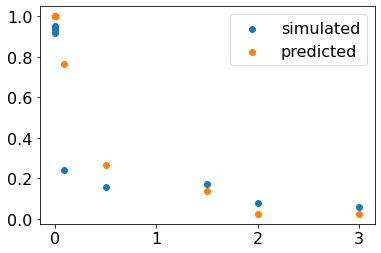

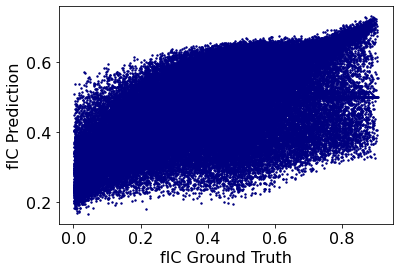

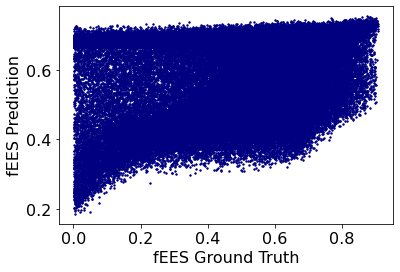

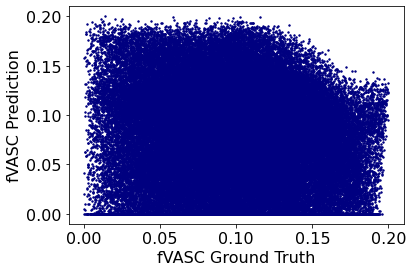

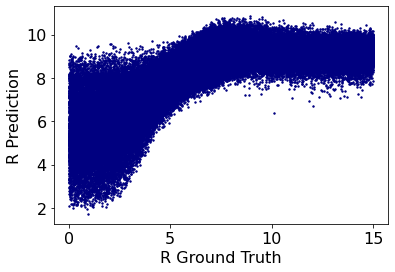

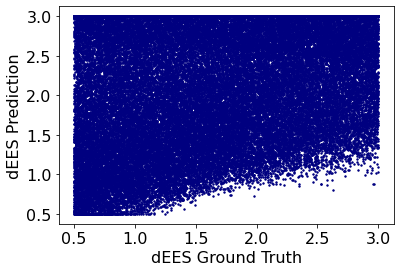

[(0.5692548831050426, 0.0), (0.14555739630112174, 0.0), (-0.1516233935894825, 0.0), (0.7786114750297134, 0.0), (0.2498306012801334, 0.0)]


In [79]:
# check predicted signal against simulated signal

plt.scatter(b_values, E_vox[0,:], label='simulated')
plt.scatter(b_values, X_real_pred[0,:], label='predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param = [fic, fees, fvasc, radii, dees]
param_f = [f_ic, f_ees, f_vasc, r, d_ees]
param_name = ['fIC', 'fEES', 'fVASC', 'R', 'dEES']
rvals = []

for i,_ in enumerate(param):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param[i], param_f[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param[i]), np.squeeze(param_f[i])))
    plt.tight_layout
    plt.show()

print(rvals)



### Bias-variance calculations
+ this section crashes when using 100,000 voxels, although my laptop did switch off. 

In [80]:

## bias-variance calculations

bias_fic = torch.mean(f_ic - fic)
bias_fees = torch.mean(f_ees - fees)
bias_r = torch.mean(r - radii)
bias_dees = torch.mean(d_ees - dees)

var_fic = torch.mean((f_ic - torch.mean(f_ic))**2)
var_fees = torch.mean((f_ees - torch.mean(f_ees))**2)
var_r = torch.mean((r - torch.mean(r))**2)
var_dees = torch.mean((d_ees - torch.mean(d_ees))**2)

mse_fic = torch.mean((f_ic - fic)**2)
mse_fees = torch.mean((f_ees - fees)**2)
mse_r = torch.mean((r - radii)**2)
mse_dees = torch.mean((d_ees - dees)**2)

print(bias_fic, bias_fees, bias_r, bias_dees)
print(var_fic, var_fees, var_r, var_dees)
print(mse_fic, mse_fees, mse_r, mse_dees)


r = r*1e6
d_ees = d_ees*1e9


: 

: 

### Bias-variance calculations using numpy

In [ ]:

'''
bias_fic = np.mean(f_ic - fic)
bias_fees = np.mean(f_ees - fees)
bias_r = np.mean(r - radii)
bias_dees = np.mean(d_ees - dees)

var_fic = np.mean((f_ic - np.mean(f_ic))**2)
var_fees = np.mean((f_ees - np.mean(f_ees))**2)
var_r = np.mean((r - np.mean(r))**2)
var_dees = np.mean((d_ees - np.mean(d_ees))**2)

mse_fic = np.mean((f_ic - fic)**2)
mse_fees = np.mean((f_ees - fees)**2)
mse_r = np.mean((r - radii)**2)
mse_dees = np.mean((d_ees - dees)**2)

print(bias_fic, bias_fees, bias_r, bias_dees)
print(var_fic, var_fees, var_r, var_dees)
print(mse_fic, mse_fees, mse_r, mse_dees)'''

'\nbias_fic = np.mean(f_ic - fic)\nbias_fees = np.mean(f_ees - fees)\nbias_r = np.mean(r - radii)\nbias_dees = np.mean(d_ees - dees)\n\nvar_fic = np.mean((f_ic - np.mean(f_ic))**2)\nvar_fees = np.mean((f_ees - np.mean(f_ees))**2)\nvar_r = np.mean((r - np.mean(r))**2)\nvar_dees = np.mean((d_ees - np.mean(d_ees))**2)\n\nmse_fic = np.mean((f_ic - fic)**2)\nmse_fees = np.mean((f_ees - fees)**2)\nmse_r = np.mean((r - radii)**2)\nmse_dees = np.mean((d_ees - dees)**2)\n\nprint(bias_fic, bias_fees, bias_r, bias_dees)\nprint(var_fic, var_fees, var_r, var_dees)\nprint(mse_fic, mse_fees, mse_r, mse_dees)'